# News preprocessing

Pre-processed to remove URLs, symbols. That is, things that are not words.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn') 

In [2]:
import re #regexp

NLTK (Natural Language Tool Kit) Tokenizer based on regular expressions. 

In [3]:
from nltk.tokenize import RegexpTokenizer

### Cleaning the dataset
We load the news dataset

C:\Users\Ivan Andika\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'keywords', 'meta_keywords',
       'meta_description', 'tags', 'summary', 'source'],
      dtype='object')


C:\Users\Ivan Andika\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,11,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'keywords', 'meta_keywords',
       'meta_description', 'tags', 'summary', 'source'],
      dtype='object')


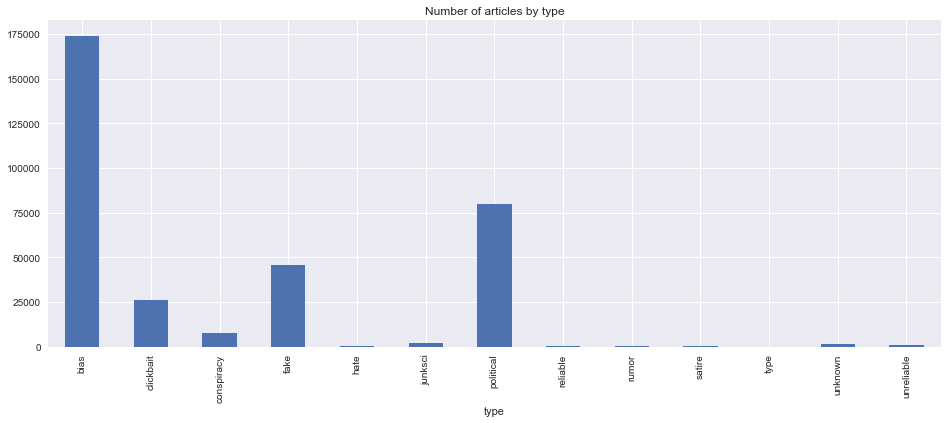

In [4]:
# news = pd.read_csv("../data/news_sampled.csv", nrows=200_000)
news = pd.read_csv("../data/news_cleaned_2018_02_13.csv", nrows=200_000, index_col=0)
news = news[news['type']!='bias']
news = news[news['type']!='clickbait']

print(news.columns)
#Load dataset for avoiding unbalance.
click_bias = pd.read_csv("../data/click_bias_only.csv", nrows=200_000, index_col=0)
print(click_bias.columns)

news = pd.concat([news, click_bias])
# print(news.applymap(type)) # Print unique types for each column
del(click_bias)

fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()
# print(news.applymap(type)) # Print unique types for each column

We fixed the bias imbalance of the dataset. 

In [5]:
news = pd.concat([news[news['type'] == 'bias'].head(60000).copy(), news[news['type'] != 'bias'].copy()])

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

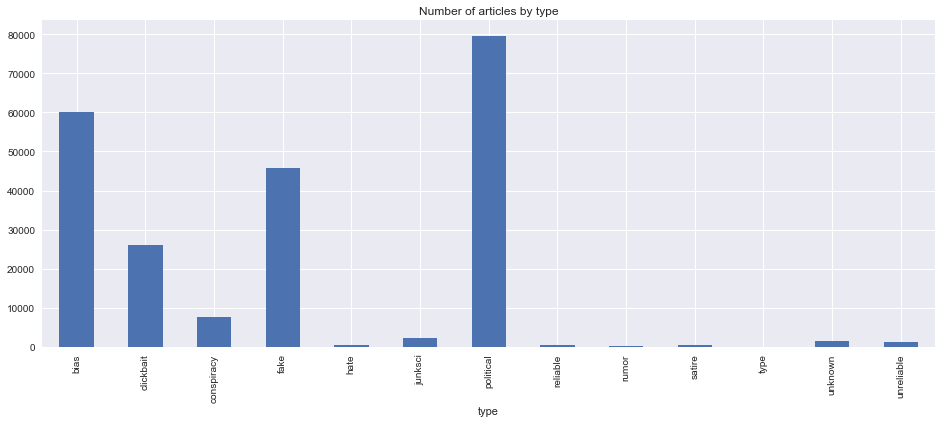

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [7]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

We clean the fields that we will use: Title and content 

In [8]:
#Clean content
news['content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['content'].str.len() >= 1]

C:\anaconda3\envs\tf-gpu\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/225034 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/225034 [00:00<?, ?it/s]

In [9]:
news.head(3)

,type,content,title
132,bias,"[Lila, Rose, president, of, the, pro, group, L...","[Biggest, pro, goal, Defunding, abortionists]"
133,bias,"[The, mobile, shortcut, will, then, be, added,...","[Discussion, Guidelines]"
134,bias,"[Two, black, leaders, who, were, prevented, fr...","[Protesters, against, genocide, of, abortion, ..."


The news is organized in the following categories 

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

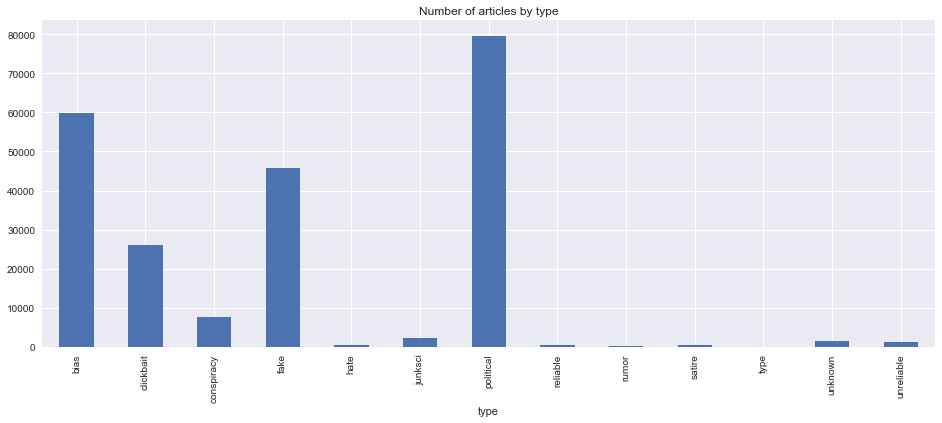

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

From here, and based on the descriptions of [OpenSources](http://www.opensources.co) (from which the dataset labels have been taken) we can group several categories. For instance:
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * unreliable
       * fake
   * **Bias**
       * bias
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

We turn groups into new ones

In [11]:
def convert_tag(tag):
    """Convert a tag to one of the three groups (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [12]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply:   0%|          | 0/224918 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

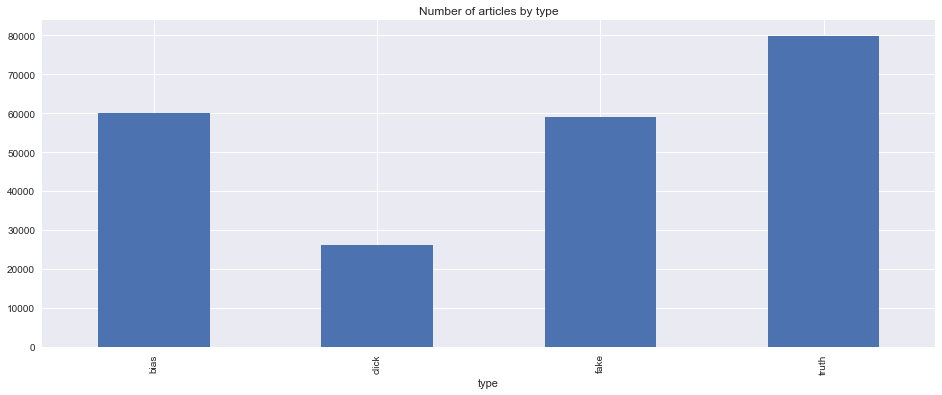

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

The dataset is quite unbalanced. In order to properly train the neural networks, the number of samples per category must be more equal. 

In this case, we create a function to select the examples we want for each category. Those that are underrepresented will be oversampled. 

In [14]:
def equalize_categories(dataframe, categories):
    """
    This function takes a dataset and sets the number of samples of each
    class to the specified in the categories param
    :param dataframe (pandas DF)
    :param categories (dict) dictionary with the number of samples desired per class
    """
    #Copy dataframe structure
    df = dataframe.iloc[0:0]
    
    for cat in categories:
        selection = dataframe[dataframe['type'] == cat]
        count = selection['type'].count()
        if count >= categories[cat]:
            df = pd.concat([df, selection.head(categories[cat])])
        else:
            #Add n times the block
            block = dataframe.iloc[0:0]
            times = int(categories[cat] / count)    
            for i in range(times+1):
                block = pd.concat([block, selection])
            #Remove the remaining
            df = pd.concat([df, block.head(categories[cat])])
    
    return df

In [15]:
cats = {
    'bias': 50_000,
    'click': 50_000,
    'fake': 50_000,
    'truth': 50_000
}
equalized = equalize_categories(news, cats)

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

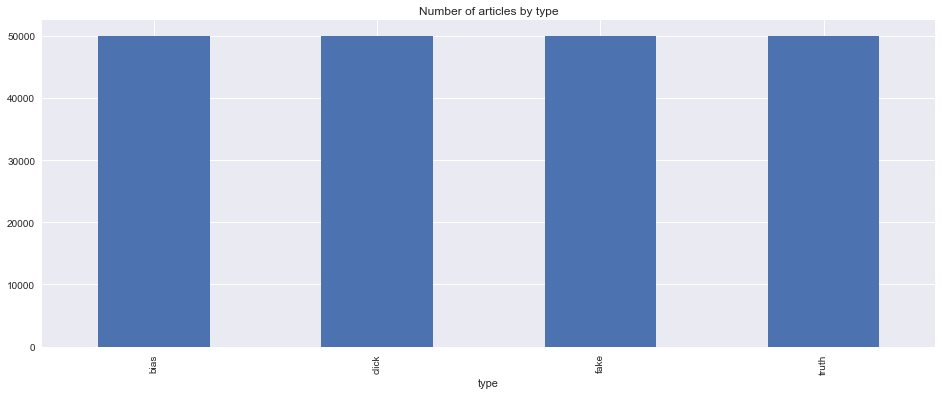

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
equalized.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [17]:
#del(news)
news = equalized.copy()
del(equalized)

### Word2Vec

In [18]:
from gensim.models import KeyedVectors

We load the vectors of a model trained by Google with the texts of millions of news 

In [19]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

An example of predicting words similar to "Trump" 

In [20]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103921413421631),
 ('Apprentice', 0.47915542125701904),
 ('Paladino', 0.4655587077140808),
 ('Snooki', 0.4468839764595032),
 ('Harrah', 0.44451743364334106),
 ('MGM_Mirage', 0.4422535300254822),
 ('Vince_McMahon', 0.44097137451171875),
 ('Limbaugh', 0.4399239420890808),
 ('Palin', 0.438370943069458),
 ('Giuliani', 0.4358450472354889)]

We then convert the words from the news headline and content to the Word2Vec vocabulary indexes. 

In [21]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

In [22]:
news['content'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['content'] if x in model.vocab], axis=1)

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Delete the articles without title (Word2Vec did not have the original words) 

In [23]:
news = news[news['title'].map(len) >= 1]

In [24]:
#Reset index
news = news.reset_index().drop("index", axis=1)


But there is a **problem**: The network input cannot be variable. To solve this, it is necessary to add padding to all the arrays, so that they all have a physical length. 

If they are less than a certain length $n$ ($l <n$) then "elements" with zeros will be added until the necessary dimensions are reached. If it is longer, it will be truncated such that $l = n$

In [25]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

You need to find a `token_len` that is sufficient to generally cover the length of all items. 

<AxesSubplot:title={'center':'Number of tokens in the article'}, ylabel='Frequency'>

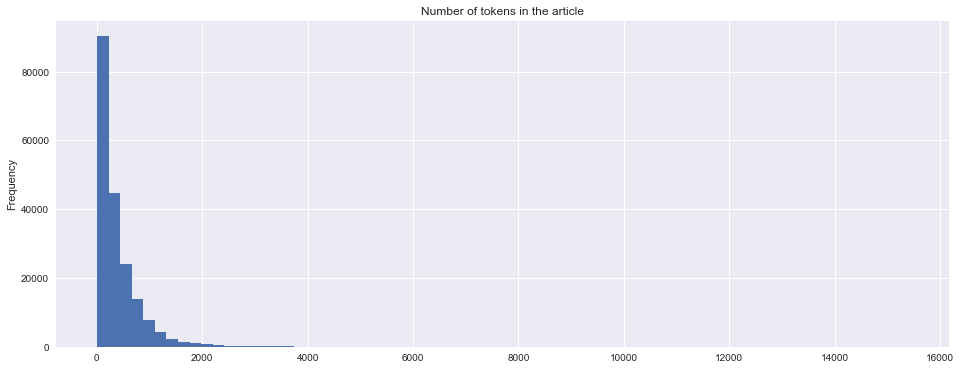

In [26]:
# Length in tokens of each news 
tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [27]:
print("Average number of tokens per item : {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item : {}".format(int(np.std(tokens_numbers))))
print("Median tokens per item : {}".format(int(np.median(tokens_numbers))))

Average number of tokens per item : 397
Standard deviation of tokens per item : 579
Median tokens per item : 249


Escogemos el número máximo como $mean + 2\sigma$

In [28]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))

Chosen token window: 1556 - Covers 97.0315687025667% of the dataset


In [29]:
n_tokens = max_tokens

In [30]:
news['content'] = news.apply(lambda r: pad_array(r['content'], n_tokens) , axis=1) #n_tokens

Same for titles 

Average number of tokens per item: 6
Standard deviation of tokens per item: 3
Median tokens per item : 7
Chosen token window: 14 - Covers 97.9364898584637% of the dataset


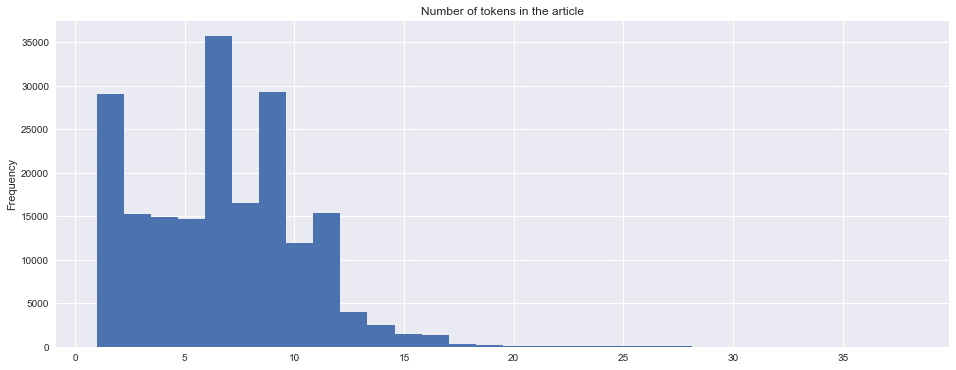

In [31]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Average number of tokens per item: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item: {}".format(int(np.std(tokens_numbers))))
print("Median tokens per item : {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))

In [32]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)

Pandas Apply:   0%|          | 0/193166 [00:00<?, ?it/s]

### Convert Target Variable to One Hot Encoding 

In [33]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [34]:
news.head()

,type,content,title,one_hot_label
0,bias,"[3958, 348, 11, 2261, 229, 4549, 5498, 115, 44...","[28009, 2261, 432, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0]"
1,bias,"[7, 1077, 34953, 23, 145, 16, 264, 14, 27, 737...","[27611, 24045, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 0, 0, 0]"
2,bias,"[893, 987, 618, 31, 37, 5622, 17, 9425, 586, 1...","[15439, 103, 9090, 3993, 202, 288, 0, 0, 0, 0,...","[1, 0, 0, 0]"
3,bias,"[7, 1042, 17, 48, 43, 193, 28, 1446, 4, 3864, ...","[9274, 10600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0]"
4,bias,"[73, 448, 344, 24, 1044, 402, 8586, 2014, 841,...","[2795, 14194, 31675, 6329, 1607, 10844, 5, 630...","[1, 0, 0, 0]"


We save the processed dataset as .pickle (python object serialized). 

In [35]:
news.to_pickle('../data/news_proc_12_3_19.pickle')

We save the processed dataset as `.csv`. 

In [36]:
news.to_csv('../data/news_proc_8_3_19.csv', sep=';')

In [37]:
from ast import literal_eval


In [38]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', 
                       sep=';', converters={'content':literal_eval, 
                                       'title':literal_eval, 
                                       'one_hot_label':literal_eval})

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
#TEST TO LOAD AND THEN MAKE A PARALLELIZED APPLY 

In [ ]:
news = pd.read_csv('../data/news_proc_8_3_19.csv', sep=';')

In [ ]:
news['title'] = news.swifter.apply(lambda r: literal_eval(r['title']), axis= 1)
news['content'] = news.swifter.apply(lambda r: literal_eval(r['content']), axis= 1)
news['one_hot_label'] = news.swifter.apply(lambda r: literal_eval(r['one_hot_label']), axis= 1)